## 0. 들어가며  

#### 0. 목표
- Semantic Segmentation(시맨틱 세그멘테이션)을 이용해서  
  자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고  
  모델을 만들어볼 것  
  <- 앞서서는 [Semantic Segmentation 다양한 모델](https://github.com/ga0808/GoingDeeper_CV/tree/main/%5BCV-9%5D%20Segmentation%20(FCN%2C%20U-Net%2C%20DeepLab) 배웠음  
  -> U-Net 으로 이미지 입력 시 도로 영역 Segmentation 하는 모델 생성하는 것이 목표  
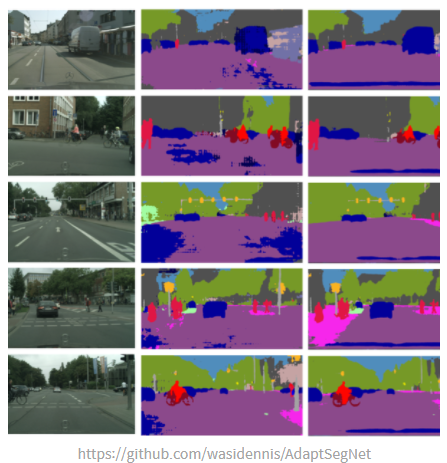


- 최종 출력 이미지  
  입력 이미지 위에 도로 영역으로 인식된 부분  
  흰색으로 오버레이한 이미지  
  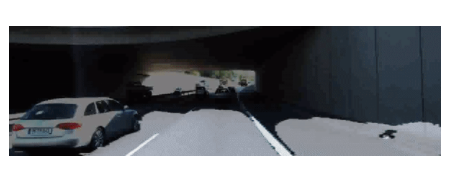  
  
#### 1. 실습목표
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.  
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.  
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.  

#### 2. 학습내용  
1) 시맨틱 세그멘테이션 데이터셋  
2) 시맨틱 세그멘테이션 모델  
3) 시맨틱 세그멘테이션 모델 시각화  

-----

## 1. U-Net, U-Net++


## 2. 시맨틱 세그멘테이션 데이터셋  

#### Step.0  이미지,데이터 가져오기  
- 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱해야함  
- [KITTI 데이터셋의 세그멘테이션 데이터](http://www.cvlibs.net/datasets/kitti/eval_semantics.php) 다운로드  



In [1]:
# 디렉토리 준비 (이미해서, 생략)
#! mkdir -p ~/aiffel/semantic_segmentation/data
#! ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/

- 데이터셋에서 확인할 수 있는 이미지, 라벨  
  라벨 보통 텍스트로 되어있는데  
  세그멘테이션 데이터는 이미지 형태의 라벨  
  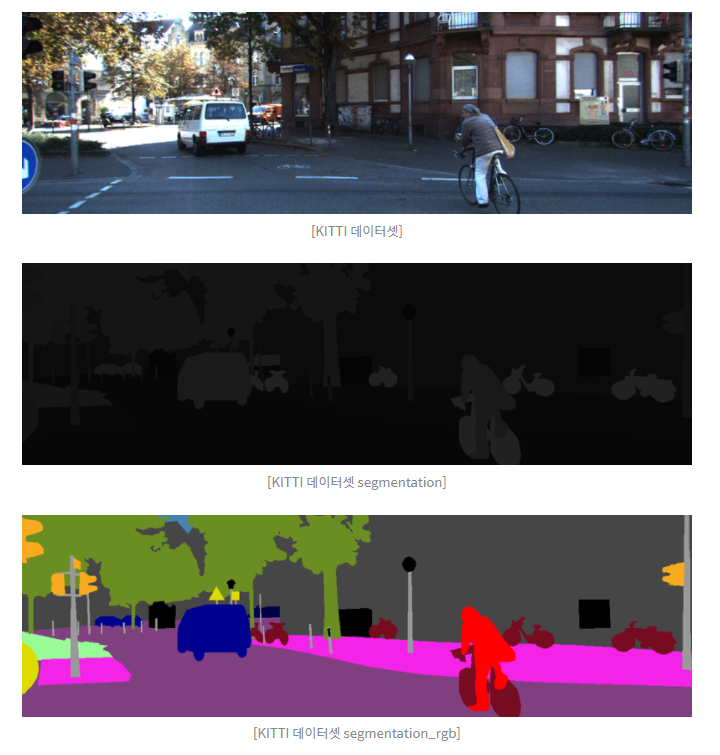  
  
- [라벨 정보 참고](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)  

- Semantic Segmentation의 이미지 라벨의 각 픽셀 값 유의미  
  -> 그럼 우리가 찾아내야 할 도로의 라벨의 값은?  
  -> 7


#### Step.1 데이터 로더(data loader) 만들기  
- 모델을 학습시킬 수 있는 데이터 로더(data loader) 생성  
  -> 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 함  
  
  
- 데이터 로더에 augumentation 적용 예정  
  -> 파이썬에서 많이 사용되는 albumentations 사용  
  (augumentation은 imgaug 등 다른 라이브러리 사용 당연히 가능)  


- 데이터로더 구현시 참고자료  
  1) [Keras Sequence에 기반한 Dataloader](https://hwiyong.tistory.com/241)    
  2) [Albumentation을 적용한 Keras sequence](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)  

In [2]:
#augumentation 라이브러리 설치
! pip list | grep albumentations

albumentations                0.5.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [144]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

##### 1) augumentation 적용 함수 생성  
- Albumentation에서 다양한 augmentation 기법을  
  확률적으로 적용할 수 있게 해주는 Compose()의 활용예  
  -> imgaug의 Sometimes()와 유사한 기능  
  

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:       # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

- 예시로 몇개만 적용시켜보기

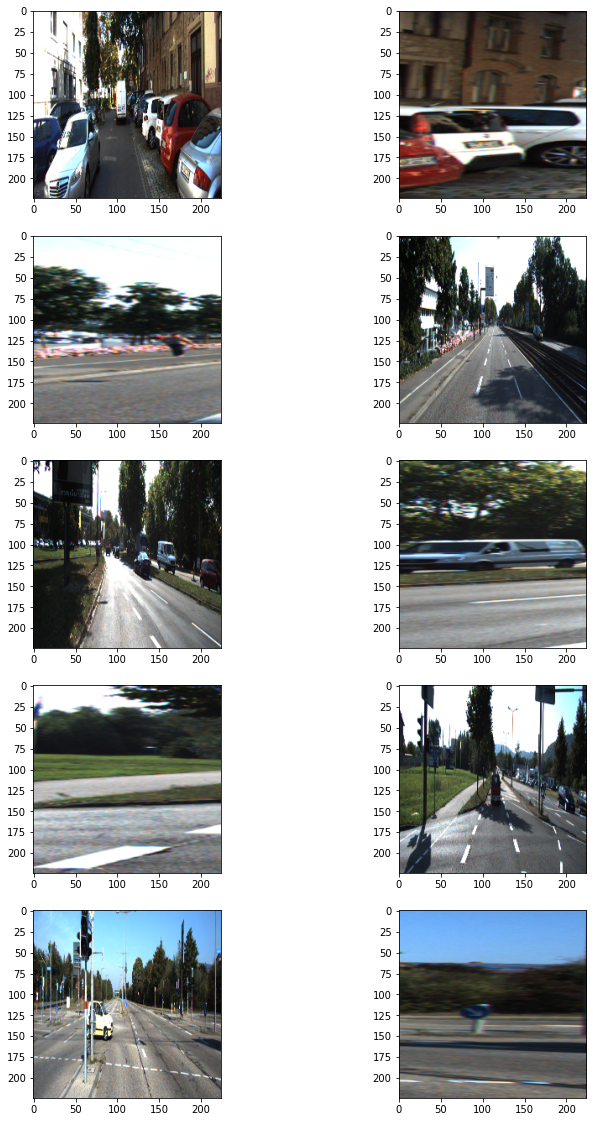

In [4]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  

plt.show()

##### 2) 데이터셋 구성  

##### 2-1)) generator 생성_ padding_U-Net  
- tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터 구성

In [122]:
class KittiGenerator(tf.keras.utils.Sequence):
    
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
    
    #dir_path: dataset의 directory path입니다.
    #batch_size: batch_size입니다.
    #img_size: preprocess에 사용할 입력이미지의 크기입니다.
    #output_size: ground_truth를 만들어주기 위한 크기입니다.
    #is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    #augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
    
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [123]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

##### 2-2)) generator_U-Net++ 생성

In [7]:
class Plus_KittiGenerator(tf.keras.utils.Sequence):
    
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=4, #U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아wla ->배치사이즈 4로 수정
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
    
    #dir_path: dataset의 directory path입니다.
    #batch_size: batch_size입니다.
    #img_size: preprocess에 사용할 입력이미지의 크기입니다.
    #output_size: ground_truth를 만들어주기 위한 크기입니다.
    #is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    #augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
    
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [14]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_plus_generator = Plus_KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_plus_generator = Plus_KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 3. 시맨틱 세그멘테이션 모델  
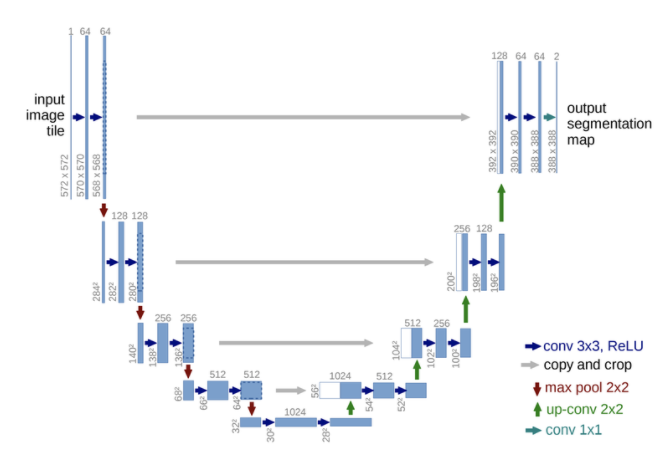  

#### Step.2 모델 구조 만들기  

- 비교적 구현이 단순한 U-Net 구현  
- 입력 이미지 크기 : 위에서 만든 데이터셋에 맞춤  


- 필요한 레이어와 연산  
  Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout 등  
  밑 모델에서는 padding 적용하고 구현 (논문에서는 적용하지 않음)  

##### 1) padding 있는 U-NET

In [124]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
      #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [125]:
unet_model = build_model(input_shape=(224, 224, 3))
unet_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_673 (Conv2D)             (None, 224, 224, 64) 1792        input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_674 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_673[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_80 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_674[0][0]                 
___________________________________________________________________________________________

##### 2) U-Net ++  

###### 2-1)) U-Net++ 기본 개념  
  -> 기존에 단순 + 세그멘테이션 효과 발휘한 U-Net 네트워크 구조에  
  +DenseNet 아이디어로 성능 개선한 모델  
  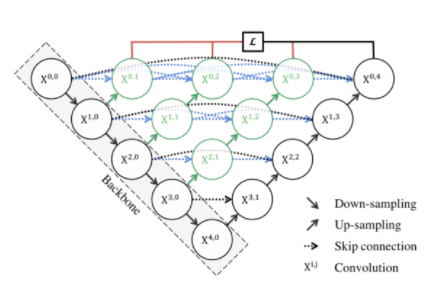  
  
  -> 모델 구조 자체는 설명없이 직관적으로 이해 가능  
  (U-Net 조금만 수정 확장하면 충분히 구현 가능)  
  
  
  -> 동일 이미지의 IoU 값 얻어서, 기존 U-Net과 비교해보자  
  
  -> [U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)  
  
##### 2-2)) U-Net ++  모델생성  

In [98]:
def plus_build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)

    # X0,1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    # X1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    # X2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    # X3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    # X0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    # X1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    # X2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

    # X0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    # X0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)
    
    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [100]:
plus_unet_model = plus_build_model(input_shape=(224, 224, 3))
plus_unet_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_571 (Conv2D)             (None, 224, 224, 64) 1792        input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_572 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_571[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_68 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_572[0][0]                 
___________________________________________________________________________________________

#### Step4. 모델 학습  
- 적절한 learning rate와 epoch를 찾아서 모델을 학습 & 저장  

##### 1) padding+ U-Net

In [126]:
unet_model = build_model()
unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=10,
 )

unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
unet_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/10
43/43 [==============================] - 46s 619ms/step - loss: 0.6908 - val_loss: 0.5486
Epoch 2/10
43/43 [==============================] - 26s 608ms/step - loss: 0.2311 - val_loss: 0.1032
Epoch 3/10
43/43 [==============================] - 26s 606ms/step - loss: 0.1259 - val_loss: 0.0975
Epoch 4/10
43/43 [==============================] - 26s 606ms/step - loss: 0.1022 - val_loss: 0.1102
Epoch 5/10
43/43 [==============================] - 26s 606ms/step - loss: 0.0964 - val_loss: 0.0917
Epoch 6/10
43/43 [==============================] - 26s 606ms/step - loss: 0.0825 - val_loss: 0.0808
Epoch 7/10
43/43 [==============================] - 26s 606ms/step - loss: 0.0714 - val_loss: 0.0665
Epoch 8/10
43/43 [==============================] - 26s 605ms/step - loss: 0.0648 - val_loss: 0.0662
Epoch 9/10
43/43 [==============================] - 26s 605ms/step - loss: 0.0599 - val_loss: 0.0802
Epoch 10/10
43/43 [==============================] - 26s 606ms/step - loss: 0.0672 - val_lo

##### 2) U-Net++

In [130]:
plus_unet_model = plus_build_model()
plus_unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
plus_unet_model.fit_generator(
     generator=train_plus_generator,
     validation_data=test_plus_generator,
     steps_per_epoch=len(train_generator),
     epochs= 10,
 )

plus_unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'
plus_unet_model.save(plus_model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/10
43/43 [==============================] - 86s 2s/step - loss: 0.5948 - val_loss: 0.1019
Epoch 2/10
43/43 [==============================] - 82s 2s/step - loss: 0.1260 - val_loss: 0.0946
Epoch 3/10
43/43 [==============================] - 82s 2s/step - loss: 0.0841 - val_loss: 0.0747
Epoch 4/10
43/43 [==============================] - 82s 2s/step - loss: 0.0650 - val_loss: 0.0712
Epoch 5/10
43/43 [==============================] - 82s 2s/step - loss: 0.0987 - val_loss: 0.2621
Epoch 6/10
43/43 [==============================] - 82s 2s/step - loss: 0.1130 - val_loss: 0.0910
Epoch 7/10
43/43 [==============================] - 82s 2s/step - loss: 0.0759 - val_loss: 0.1042
Epoch 8/10
43/43 [==============================] - 82s 2s/step - loss: 0.0678 - val_loss: 0.0699
Epoch 9/10
43/43 [==============================] - 81s 2s/step - loss: 0.0650 - val_loss: 0.0681
Epoch 10/10
43/43 [==============================] - 81s 2s/step - loss: 0.0713 - val_loss: 0.0705


## 4. 시맨틱 세그멘테이션 모델 시각화  
##### 1) 학습된 모델 가져오기  
- 이전 스텝 학습 오래걸려서 3 epoch로 정상 작동만 확인  
  시각화 확인하기 위해 미리 학습된 모델 가져오기  

In [131]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
plus_unet_model_path  = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

unet = tf.keras.models.load_model(unet_model_path)
plus_unet = tf.keras.models.load_model(plus_unet_model_path)

##### 2) 결과 이미지 시각화 함수 생성 : get_output()
- 테스트 셋은 이미지를 제공하지만, 정답 데이터를 제공하진 않음  
  -> 그래서 눈으로 확인할 수 있도록  
  모델이 추론(inference)한 결과를 시각화된 세그멘테이션 이미지 생성  
  -> 입력 이미지, 라벨 한 번에 볼 수 있도록 출력값을 입력 이미지 위에 겹쳐서 보이도록 = 오버레이(overray)하기  
  -> PIL 패키지 사용하면 Image.blend 활용 가능  
  
  

In [132]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

##### 3) 함수로 시각화

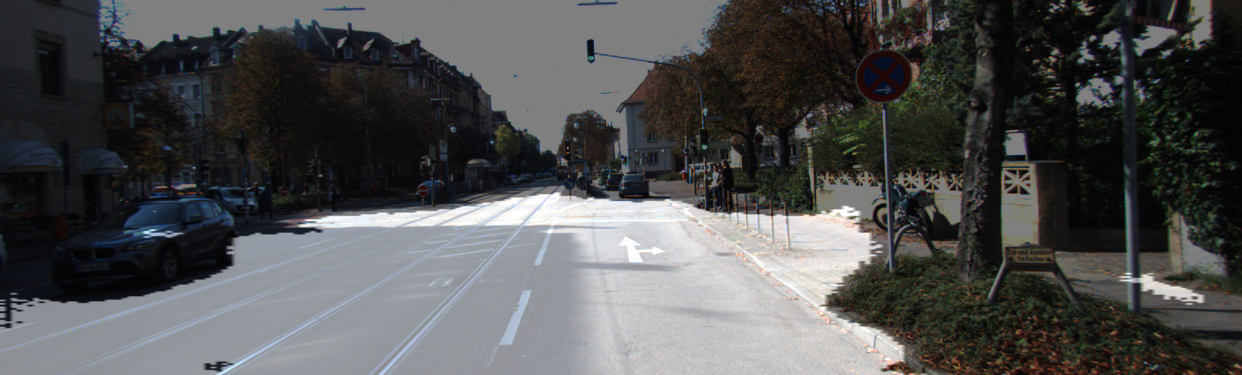

In [133]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라짐 

#unet
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

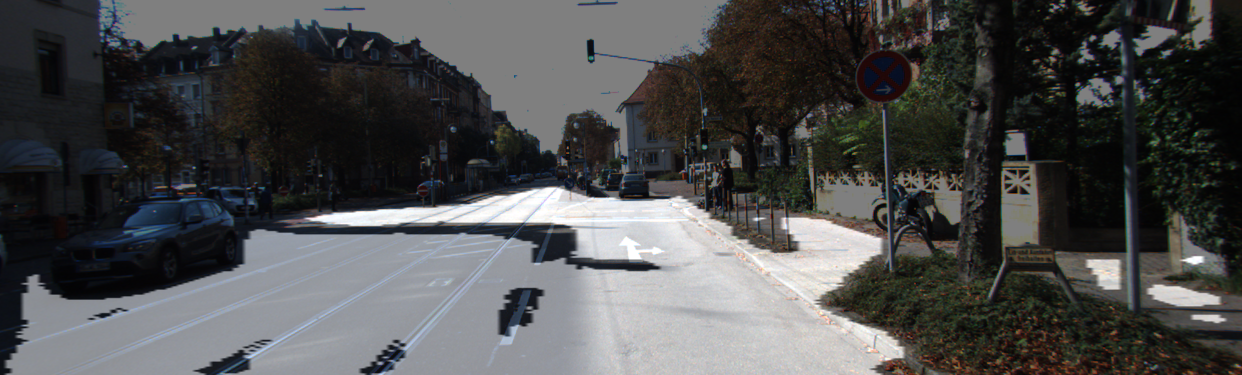

In [134]:
#plus_unet_model
get_output(
     plus_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

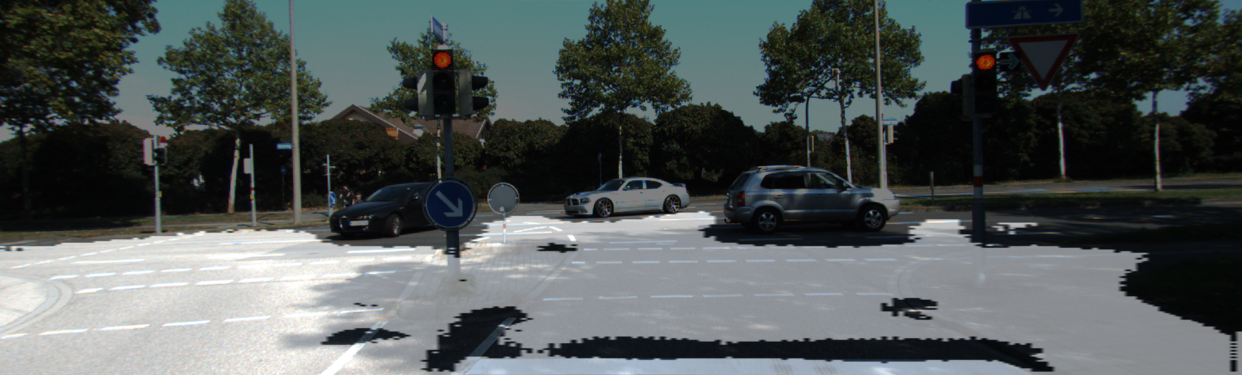

In [135]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라짐 

#unet
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

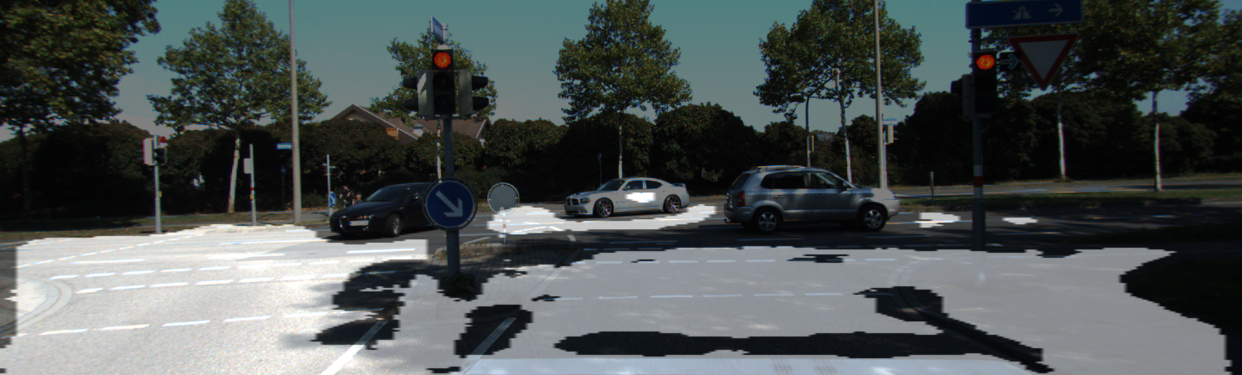

In [136]:
#plus_unet_model
get_output(
     plus_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

##### 4) 세그멘테이션 성능 측정 : IoU  
- IoU(Intersection over Union) 계산하기 위해  
  -> 모델이  
  도로 영역 판단 부분 = 1, 나머지 부분 = 0 표시된 행렬 필요  
  (predicton)  
  
  -> 라벨 데이터에서  
  도로영역= 1, 나머지 부분= 0 표시된 행렬 필요  
  (target)  
  
##### 4-1)) 결과 이미지 시각화 함수 수정 :  get_output()  
 - 위에서 구현했던 get_output을 좀 더 확장해서  
   output, prediction, target 함께 리턴하도록 구현  
 

In [137]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

##### 4-2)) IoU 계산 함수 생성  

In [138]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

##### 4-3)) IoU 결과 확인  

In [139]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 

output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.557438


0.557437898543828

In [140]:
output, prediction, target = get_output(
     plus_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.537814


0.5378136038402319

In [141]:
unet_iou = []
plus_unet_iou = []

for i in range(50):  # 이미지 50개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output(
         unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou_score(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output(
         plus_unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    plus_unet_iou.append(calculate_iou_score(target, prediction))

IoU : 0.596573
IoU : 0.543206
IoU : 0.839284
IoU : 0.793444
IoU : 0.715554
IoU : 0.689367
IoU : 0.603149
IoU : 0.627158
IoU : 0.556713
IoU : 0.579006
IoU : 0.557438
IoU : 0.537814
IoU : 0.420312
IoU : 0.474743
IoU : 0.630835
IoU : 0.598808
IoU : 0.524608
IoU : 0.506607
IoU : 0.581859
IoU : 0.538396
IoU : 0.592567
IoU : 0.562459
IoU : 0.651514
IoU : 0.605305
IoU : 0.623056
IoU : 0.556362
IoU : 0.485526
IoU : 0.452714
IoU : 0.471406
IoU : 0.326463
IoU : 0.737998
IoU : 0.625045
IoU : 0.764191
IoU : 0.646994
IoU : 0.762654
IoU : 0.613911
IoU : 0.439975
IoU : 0.521936
IoU : 0.592820
IoU : 0.588619
IoU : 0.588751
IoU : 0.688549
IoU : 0.547316
IoU : 0.570705
IoU : 0.787670
IoU : 0.749460
IoU : 0.765844
IoU : 0.807895
IoU : 0.670453
IoU : 0.677227
IoU : 0.590899
IoU : 0.624819
IoU : 0.591388
IoU : 0.619331
IoU : 0.685104
IoU : 0.680857
IoU : 0.681352
IoU : 0.669011
IoU : 0.555096
IoU : 0.544621
IoU : 0.584946
IoU : 0.592937
IoU : 0.473341
IoU : 0.515882
IoU : 0.624298
IoU : 0.652999
IoU : 0.70

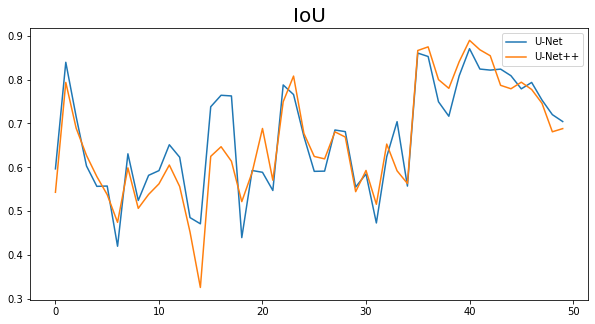

In [142]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(plus_unet_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

In [145]:
# IoU 평균 비교
df_iou = pd.DataFrame({'U-Net': unet_iou,
                       'U-Net++': plus_unet_iou})
df_iou.mean()

U-Net      0.668820
U-Net++    0.659254
dtype: float64

## 회고  

### 💚루브릭  
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?   
KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어  
세그멘테이션 결과 이미지를 제출  


2. U-Net++ 모델이 성공적으로 구현되었는가?  
U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행  


3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?  
U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인  


### 💚회고  
논문에서는 non-padding 으로 진행했는데  
해당 노드 컨텐츠는 padding을 적용해서 Unet을 구현함  
-> 그래서 non-padding 모델을 생성하고자 했는데 시간내에 하지 못함  
-> 복습시, 재도전 !!  
   
### 💚참고자료  
1) [zhixuhao/unet_github](https://github.com/zhixuhao/unet)  
2) [pytorch_unet_github](https://github.com/4uiiurz1/pytorch-nested-unet)  
3) [Andy-zhujunwen_github](https://github.com/Andy-zhujunwen/UNET-ZOO)  
4) [MrGiovanni/UNet++_github](https://github.com/MrGiovanni/UNetPlusPlus) : including unet,unet++,attention-unet,r2unet,cenet,segnet ,fcn.  
5) [Raziel-JKM_github](https://github.com/Raziel-JKM/Practice/blob/main/GoingDeeper/05/GD10.ipynb)